# ANOVA - Analysis of Variance
Today, we will be learning ANOVA, a generalized form of comparing mean across multiple groups. 
Agenda today:
1. Compare t-tests and ANOVA
2. Differentiate between variance between groups and variance within groups
3. Implement ANOVA in Python
    - using scipy
    - from scratch
    - using statsmodels
        - Discuss the relationship between ANOVA and Linear Regression.
4. Demo of a post hoc test (Tukey Test)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## T tests or ANOVA?
**ANOVA** or *Analysis Of Variance*  provides a statistical test of whether two or more population means are equal, and therefore generalizes the t-test beyond two means.

Suppose we want to compare whether multiple groups differ in some type of measures. For example, we have collected mood data grouped by four types of weather - sunny, raining, overcast, or cloudy, and we want to find out whether there is a difference in mood across different weather. What tests would you use?

A natural reaction would be to conduct multiple t-tests. However, that comes with many drawbacks. First, you would need $\frac{n(n-1)}{2}$ t tests, which come out to 6 tests. Having more tests meaning having higher chance of making type I error. In this case, our original probability of making type I error grew from 5% to 5% x 6 = 30%! By conducting 6 tests and comparing their mean to each other, we are running a huge risk of making false positives. This is known as the multiple comparison problem. 

Let's demonstrate this below:

In [2]:
# Set random seed for reproducibility
np.random.seed(2021)
# Create a numpy array with 100 observations
p_values = np.zeros(100)
# Run a for loop with 100 iterations
for iteration in range(100):
    # Create a normal distribution
    population = stats.norm(0,1)
    # Draw two samples from the same distribution
    first_sample = population.rvs(50)
    second_sample = population.rvs(50)
    # Run a ttest on the data to evaluate
    # whether there is significant difference
    # between samples
    test = stats.ttest_ind(first_sample, second_sample)
    # Collect the pvalue from the test
    pvalue = test.pvalue
    # Round the pvalue for comparison
    pvalue = round(pvalue, 2)
    # Add the pvalue to the numpy array
    p_values[iteration] = pvalue

# Count the number of times a pvalue is less than
# or equal to .05
false_positives = (p_values <= .05).sum()

# Print the number of times we found
# a significant difference between samples
# drawn from the same population.
print('Out of 100 tests, we had {} false positives.'.format(false_positives))

Out of 100 tests, we had 5 false positives.


How then, can we combat this? -- ANOVA!

Instead of looking at each individual difference, ANOVA examines the ratio of variance between groups, and variance within groups, to find out whether the ratio is big enough to be statistically significant. 

#### T Test statistics 
##### One sample
$t = \frac{x\bar - \mu}{\frac{s}{\sqrt n}}$

##### Two sample
$$ t = \frac{\bar{x_1} - \bar{x_2}}{\sqrt{s^2 \left( \frac{1}{n_1} + \frac{1}{n_2} \right)}}$$

where $s^2$ is the pooled sample variance,

$$ s^2 = \frac{\sum_{i=1}^{n_1} \left(x_i - \bar{x_1}\right)^2 + \sum_{j=1}^{n_2} \left(x_j - \bar{x_2}\right)^2 }{n_1 + n_2 - 2} $$

We can also say that t test is a special case of ANOVA in that we are comparing the means of only two groups.


#### ANOVA - the F test
$F = \frac{MS_{bet}}{MS_{within}}$

Just like t and z tests, we calculate a test statistic, then compare it to a critical value associated with a probability distribution.  In this case, that is the f-distribution.

![fdistribution](img/f_distribution.png)

Degrees of freedom of an F-test originate from:
  - the degrees of freedom from the numerator of the f-stat (DF between)
  - the degrees of freedom from the denominator of the f-stat (DF within) 
(more below)

**When working with two samples, ANOVA is really just a "special" ttest.**

Below, let's create two samples drawn from a normal distribution

*Sample 1*
- Mean: 0
- Standard Deviation: 3
- Size: 100

*Sample 2*
- Mean: 1
- Standard Deviation: 3
- Size: 100

In [3]:
one = np.random.normal(0,3,100)
two = np.random.normal(1,3,100)

Next, we will run an ANOVA test using the `f_oneway` function from the `scipy.stats` module.

In [4]:
stats.f_oneway(one, two)

F_onewayResult(statistic=11.147155980836345, pvalue=0.001005481074424721)

Now, let's run a ttest using the `ttest_ind` function from the `scipy.stats` module.

In [5]:
t = stats.ttest_ind(one, two)
t

Ttest_indResult(statistic=-3.3387356859800015, pvalue=0.0010054810744247202)

**What do we notice about these two test results?**

Is the t-statistic related to the f-statistic?

In [6]:
# Two-sample t-stat equals F-stat squared
t.statistic**2

11.14715598083635

# Discussion:

## Which test would you run for each these scenarios:

1. The average salary per month of an English Premier League player is $240,000€$. You would like to test whether players who don't have a dominant foot make more than the rest of the league.  There are only 25 players who are considered ambidextrous. 

2. You would like to test whether there is a difference in arrest rates across neighborhoods with different racial majorities.  You have point statistics of mean arrest rates associated with neighborhoods of majority white, black, hispanic, and asian populations.

3. You are interested in testing whether the superstition that black cats are bad luck affects adoption rate.  You would like to test whether black-fur shelter cats get adopted at a different rate than cats of other fur colors.

4. You are interested in whether car-accident rates in cities where marijuana is legal differs from the general rate of car accidents.  Assume you know the standard deviation of car accident rates across all U.S. cities.



## 2. Differentiate between variance between groups and variance within groups


<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/12/image046.png" width="500">

#### Between Group Variability

Measures how much the means of each group vary from the mean of the overall population



<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/12/image0171.png" width="500">
    

#### Within Group Variability

Refers to variations caused by differences within individual groups.  

Consider the given distributions of three samples below. As the spread (variability) of each sample is increased, their distributions overlap and they become part of a big population.
<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/12/image031.png" width="500">

Now consider another distribution of the same three samples but with less variability. Although the means of samples are similar to the samples in the above image, they seem to belong to different populations.

<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/12/image033.png" width="500">


### Which of these following trios would have high f-stats, and which would have low.

In [7]:
# Create three sets of data without much difference in means
np.random.seed(42)

a = np.random.normal(20,20,20)
b = np.random.normal(22,20,20)
c = np.random.normal(19,20,20)

one = np.random.normal(20,2,20)
two = np.random.normal(22,2,20)
three = np.random.normal(19,2,20)

four = np.random.normal(20,10,20)
five = np.random.normal(20,10,20)
six = np.random.normal(23,10,20)

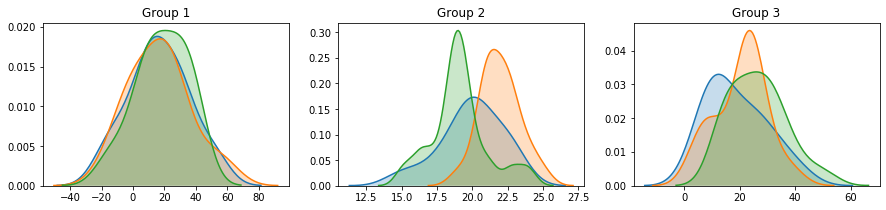

In [8]:
groups = [[a,b,c], [one,two,three], [four,five,six]]
fig, axes = plt.subplots(1,3, figsize=(15,3))

for idx in range(len(groups)):
    ax = idx%3
    for group in groups[idx]:
        sns.kdeplot(group, ax = axes[ax], shade=True)
        axes[ax].set_title('Group {}'.format(idx + 1))

Let's see how ANOVA identifies significant difference between these three examples.

In [9]:
print(stats.f_oneway(a,b,c))
print(stats.f_oneway(one,two,three))
print(stats.f_oneway(four,five,six))

F_onewayResult(statistic=0.06693195000987277, pvalue=0.9353322377145488)
F_onewayResult(statistic=11.760064743099003, pvalue=5.2985391195830756e-05)
F_onewayResult(statistic=3.194250788724835, pvalue=0.048432238619556506)


## Calculating ANOVA

In this section, we will learn how to calculate ANOVA ourselves.

In [10]:
df = pd.read_csv('bikeshare_day.csv')
df.head()
# cnt is the outcome we are trying to predict

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [11]:
# we need to conduct a little bit feature engineering to encode 
df['season_cat'] = df.season.apply(lambda x: 'spring' if x == 1 else 
                                           (
                                            'summer' if x == 2 else (
                                                'fall' if x == 3 else 'winter')
                                           )
                                      )
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_cat
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,spring
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,spring
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,spring
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,spring
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,spring


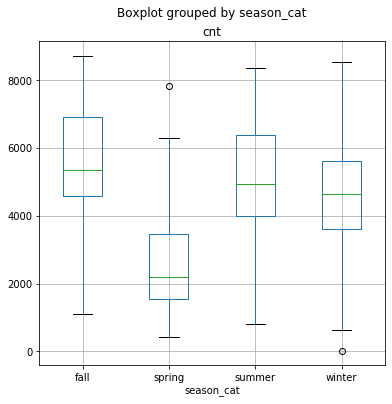

In [12]:
#Create a boxplot
# 1 is spring, 2 is summer, 3 is fall, and 4 is winter
df.boxplot('cnt', by='season_cat', figsize=(6,6))

In [13]:
# We could perform two sample t-tests for each sample.

# subset the dataframe  by season and isolate the dependent variable
spring = df[df.season_cat == 'spring'].cnt
fall = df[df.season_cat == 'fall'].cnt
summer = df[df.season_cat == 'summer'].cnt
winter = df[df.season_cat == 'winter'].cnt

# We could run independent t-tests for each combination
# But that increases the chance of making a type I (False Positive) error
# Also, as your groups increase, the number of tests may become infeasable
print(stats.ttest_ind(spring, fall))
print(stats.ttest_ind(spring, summer))
print(stats.ttest_ind(spring, winter ))
print(stats.ttest_ind(fall, summer))
print(stats.ttest_ind(fall, winter))
print(stats.ttest_ind(summer, winter))

Ttest_indResult(statistic=-20.40505135948835, pvalue=2.134072968524431e-62)
Ttest_indResult(statistic=-14.65873026929708, pvalue=1.5284822271363832e-38)
Ttest_indResult(statistic=-12.933694332032188, pvalue=1.2022067175230552e-31)
Ttest_indResult(statistic=3.9765418611661243, pvalue=8.411509811510022e-05)
Ttest_indResult(statistic=5.541003097872063, pvalue=5.7789091515026665e-08)
Ttest_indResult(statistic=1.480020595990678, pvalue=0.13974231789501412)


#### Breakdown of the calculation

Total Sum of Squares is the square of every value minus the mean means, or in other words, the variance of the entire dataset without dividing through by degrees of freedom. 
- $SS_t$ = $\sum (X_{ij} - \bar X)^2$

The total sum of squares can be broken down into the sum of squares between and the sum of squares within.
- $SS_t =  SS_b+SS_w  $

The sum of squares between accounts for variance in the dataset that comes from the difference between the mean of each sample, without dividing through by the degrees of freedom.   
Or, in other words, the weighted deviation of each mean from the mean of means:
- $SS_b$ = $\sum(n_i(\bar X - \bar X_i)^2) $

The sum of squares within accounts for variance that comes from within each sample.  That is, the sum of the variance of each group weighted by its degrees of freedom. This is really just the sum of the square of each data point's deviation from its sample mean:
- $SS_w$ = $\sum (n_i - 1) s_i ^ 2$  

Degrees of Freedom for ANOVA:
-  $DF_{between}$ = k - 1
- $DF_{within}$ = N - k
- $DF_{total}$ = N - 1

Notations:
- $\bar{X} = $ Mean of Means = Mean of entire dataset
- $X_{i}$ = An individual Sample
- $X_{ij}$ = An observation in an individual sample
- $\bar{X_{i}}$ = The mean of an individual sample
- k is the number of groups
- N is the total number of observations
- n is the number of observations in each group
- $MS$ = Mean Sum of Squares
- $DF$ = Degrees of Freedom
- $F$ = F Statistic
- $_b$ = between
- $_w$ = within

- $MS_b$ = $\frac{SS_b}{DF_b}$
- $MS_w$ = $\frac{SS_w}{DF_w}$


- $F$ = $\frac{MS_b}{MS_w}$

Like t-tests, we can also perform hypothesis testing with ANOVA. 

- $H_0$ : $\mu{_1}$ = $\mu_2$ = $\mu_3$ = $\mu_4$
- $H_a$ : $H_0$ is not true

Under the null hypothesis (and with certain assumptions), both quantities estimate the variance of the random error, and thus the ratio should be small. If the ratio is large, then we have evidence against the null, and hence, we would reject the null hypothesis.

**Quick intro to flexible arguments**

In Python, the print function can take any number of arguments:

In [14]:
print(1,2,3,4,5)
print(1)
print('First object', 2, 'third object')
print(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)

1 2 3 4 5
1
First object 2 third object
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


We can write functions that work this way too. 

To do so, we place a `*` in front of a placeholder variable when we define the function. 

In [15]:
def example(*stuff):
    return stuff

In [16]:
example(1,2,3,4,5)

(1, 2, 3, 4, 5)

In [17]:
def example(*stuff):
    count = 0
    for item in stuff:
        count += item
    return count

In [18]:
example(1,2,3,4,5)

15

Because it makes out lives easier, we will apply the same principal to the our `anova` function.

**Let's write some *code***

The goal of our function is to output a dataframe that replicates this table, which is produced by statsmodels ANOVA.

|            | df    | sum_sq       | mean_sq      | F          | PR(>F)       |
|------------|-------|--------------|--------------|------------|--------------|
| season_cat | 3.0   | 9.505959e+08 | 3.168653e+08 | 128.769622 | 6.720391e-67 |
| Residual   | 727.0 | 1.788940e+09 | 2.460715e+06 | NaN        | NaN          |

In [19]:
def anova(*samples, group_label='samples'):
    # Merge all samples into a single array
    all_samples = samples[0].append(samples[1:])
    # Calculate the mean of all samples
    overall_mean = all_samples.mean()
    # Calculate the sum of square difference
    # between all observations and the overall_mean
    ss_total = sum([(x - overall_mean)**2 for x in all_samples])
    # Calculate the sum of squared differences 
    # within each sample
    ss_within = 0
    for sample in samples:
        ss_within += ((sample - sample.mean())**2).sum()
    # Calculate the sum of squared differences
    # between the overall mean and each sample mean
    # weighted by the size of each sample
    ss_between = 0
    for sample in samples:
        ss_between += ((overall_mean - sample.mean())**2) * len(sample)
#===================================================================
          # If the weighting in the line above is confusing,
          # you could optionally just loop over each individual
          # data point in a sample and calculate the difference
          # between the overall mean and the sample mean ^squared
          # forever data point. The calculation is the same.
            
#         for observation in sample:
#             ss_between += (overall_mean - sample.mean())**2
#===================================================================  
    # Calculate the numbers of groups
    n_groups = len(samples)
    # Calculation the total numbers of observations
    n_obs = len(all_samples)
    # Calculate the degrees of freedom within 
    df_within = n_obs - n_groups
    # Calculate the mean squared difference within
    ms_within = ss_within / df_within
    # Calculate the degrees of freedom between
    df_between = n_groups - 1
    # Calculate the mean suared difference between
    ms_between = ss_between / df_between
    # Calculate the f statistic
    f = ms_between / ms_within
    # Calculate the p_value
    p_value = stats.f.sf(f, df_between, df_within)
    
    column_names = ['df', 'sum_sq', 'mean_sq', 'F', 'PR(>F)']
    data = [[df_between, ss_between, ms_between, round(f, 6), p_value],
            [df_within,  ss_within,  ms_within, np.nan, np.nan]]

    df = pd.DataFrame(data, columns=column_names, index=[group_label, 'Residual'])

    return df

In [20]:
anova(summer, fall, winter, spring, group_label = 'Seasons')

,df,sum_sq,mean_sq,F,PR(>F)
Seasons,3,9.505959e+08,3.168653e+08,128.769622,6.720391e-67
Residual,727,1.788940e+09,2.460715e+06,NaN,NaN


## Perform an ANOVA with scipy

In [21]:
anova = stats.f_oneway(df['cnt'][df['season_cat'] == 'summer'],
                df['cnt'][df['season_cat'] == 'fall'], 
                df['cnt'][df['season_cat'] == 'winter'],
                df['cnt'][df['season_cat'] == 'spring'])

anova.statistic

128.76962156570784

## 4. Calculate ANOVA using statsmodel

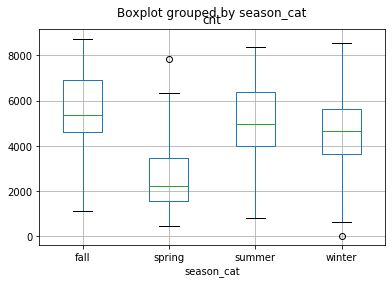

In [22]:
df.boxplot('cnt', by = 'season_cat')

In [23]:
linear_regression_model = ols('cnt~season_cat',data=df).fit()

In [24]:
# Run Anova with the linear regression model
anova_table = sm.stats.anova_lm(linear_regression_model)
print(anova_table)

               df        sum_sq       mean_sq           F        PR(>F)
season_cat    3.0  9.505959e+08  3.168653e+08  128.769622  6.720391e-67
Residual    727.0  1.788940e+09  2.460715e+06         NaN           NaN


Why are we using linear regression for ANOVA?

We haven't gotten to Linear Regression yet, but let's take a look at the table reporting the coefficients for linear regression. 

In [25]:
# Collect the summary tables from the linear regression model
regression_table = linear_regression_model.summary()
# Collect the second table which contains the coefficients
regression_table = regression_table.tables[1]
# Convert the data into a dataframe
regression_table = pd.DataFrame(regression_table.data[1:],columns = regression_table.data[0])
regression_table.head()

,,coef,std err,t,P>|t|,[0.025,0.975]
0,Intercept,5644.3032,114.407,49.335,0.000,5419.696,5868.910
1,season_cat[T.spring],-3040.1706,163.352,-18.611,0.000,-3360.869,-2719.472
2,season_cat[T.summer],-651.9717,162.673,-4.008,0.000,-971.336,-332.608
3,season_cat[T.winter],-916.1403,164.052,-5.584,0.000,-1238.213,-594.068


If we look at first column, we see the following values:

```Intercept, season_cat[T.spring], season_cat[T.summer], season_cat[T.winter]```

These values represent each of the seasons. In this case, `fall` has been set as the intercept. 

Let's calculate the mean for each of the seasons in our dataset and append them to the results table. 

In [26]:
means = df.groupby('season_cat')['cnt'].mean()

In [27]:
regression_table['means'] = means.values

Now let's subtract the fall mean from all other mean values, and save the output as another column. 

In [28]:
regression_table['mean-fall-mean'] = regression_table.means - regression_table.means[0]

In [29]:
regression_table

,,coef,std err,t,P>|t|,[0.025,0.975],means,mean-fall-mean
0,Intercept,5644.3032,114.407,49.335,0.000,5419.696,5868.910,5644.303191,0.000000
1,season_cat[T.spring],-3040.1706,163.352,-18.611,0.000,-3360.869,-2719.472,2604.132597,-3040.170595
2,season_cat[T.summer],-651.9717,162.673,-4.008,0.000,-971.336,-332.608,4992.331522,-651.971670
3,season_cat[T.winter],-916.1403,164.052,-5.584,0.000,-1238.213,-594.068,4728.162921,-916.140270


We can see that the difference between fall and the other season mean is the same as their linear regression coefficient! 

## Next steps
Just because we have rejected the null hypothesis, it doesn't mean we have conclusively showed which group is significantly different from which - remember, the alternative hypothesis is "the null is not true". 

We need to conduct post hoc tests for multiple comparison to find out which groups are different, the most prominent post hoc tests are:
- LSD (Least significant difference)
    - $t\sqrt \frac{MSE}{n^2}$
- Tukey's HSD 
    - $q\sqrt \frac{MSE}{n}$
    
https://www.statisticshowto.com/studentized-range-distribution/#qtable
    
After calculating a value for LSD or HSD, we compare each pair wise mean difference with the LSD or HSD difference. If the pairwise mean difference exceeds the LSD/HSD, then they are significantly different.

In [30]:
results = pairwise_tukeyhsd(df.cnt, df.season_cat)

In [31]:
results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
fall,spring,-3040.1706,0.001,-3460.8063,-2619.5349,True
fall,summer,-651.9717,0.001,-1070.8566,-233.0867,True
fall,winter,-916.1403,0.001,-1338.5781,-493.7025,True
spring,summer,2388.1989,0.001,1965.3265,2811.0714,True
spring,winter,2124.0303,0.001,1697.6383,2550.4224,True
summer,winter,-264.1686,0.3792,-688.8337,160.4965,False
